# Logistic Regression and SVM 

# `00` Import Libraries 

In [13]:
import numpy as np
import pandas as pd
# visulaization
import matplotlib.pyplot as plt
import seaborn as sns

#check normality
from scipy.stats import shapiro
#for Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#handling categorical feature
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#spliting data
from sklearn.model_selection import train_test_split
#evaluating models
from sklearn.metrics import classification_report, f1_score, confusion_matrix
#models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

# `01 ` Read & Split Data 

In [14]:
df = pd.read_csv('Churn_Modelling.csv').drop(columns = ['Surname', 'RowNumber'])
df.shape

(10000, 12)

In [15]:
train_data, validation_data = train_test_split(df, test_size = 0.20, random_state = 42)
print(f' Train Data shape =  {train_data.shape}')
print(f' validation Data shape =  {validation_data.shape}')

 Train Data shape =  (8000, 12)
 validation Data shape =  (2000, 12)


In [16]:
## separating the categorical features and numerical features
Id = ['CustomerId']
target = ['Exited']
num_cols = list(set(train_data.select_dtypes(exclude=[object]).columns) - set(Id + target))
cat_cols = list(train_data.select_dtypes(include=[object]).columns) 

ordinal_cols = []
nominal_cols = ['Gender', 'Geography']

print(f'Numeric data = {len(num_cols)}, Categorical data = {len(cat_cols)}')

Numeric data = 8, Categorical data = 2


## `02` EDA

In [ ]:
train_data.info()

### `2.1` Check Normality

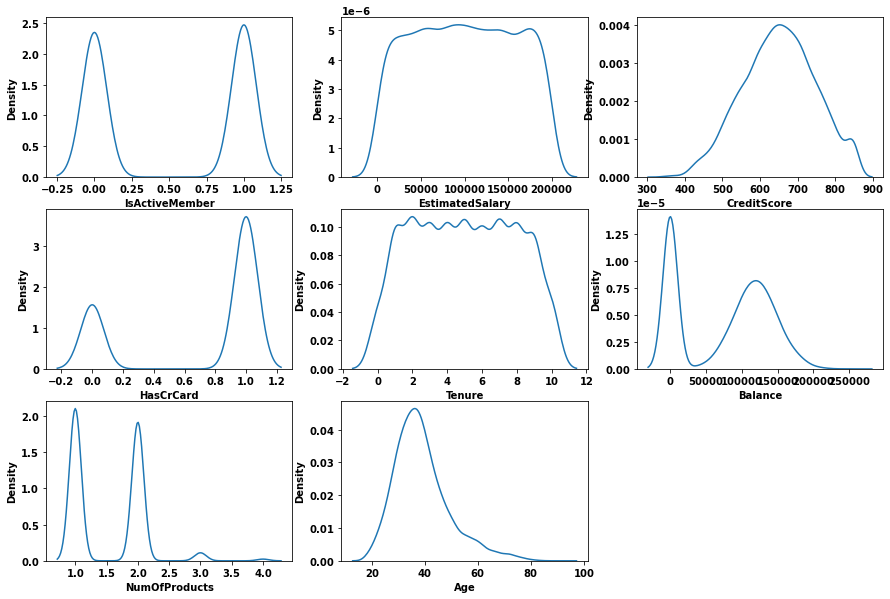

In [7]:
plt.figure(figsize=(15,10))
for i, col in enumerate(train_data[num_cols]):
    ax = plt.subplot(3, 3, i+1)
    sns.kdeplot(train_data[col], ax=ax)
plt.show()

### `2.2` Check Nulls

In [8]:
nulls_df = ((train_data.isnull().sum()/train_data.shape[0])*100).sort_values(ascending=False).reset_index().rename(columns = { 0 : "Nulls_Count"})
nulls_df[nulls_df['Nulls_Count'] > 0]


,index,Nulls_Count


### `2.3` Check Duplicates

In [9]:
#check Duplicates
train_data.duplicated().sum()

0

### `2.4` Check Outliers

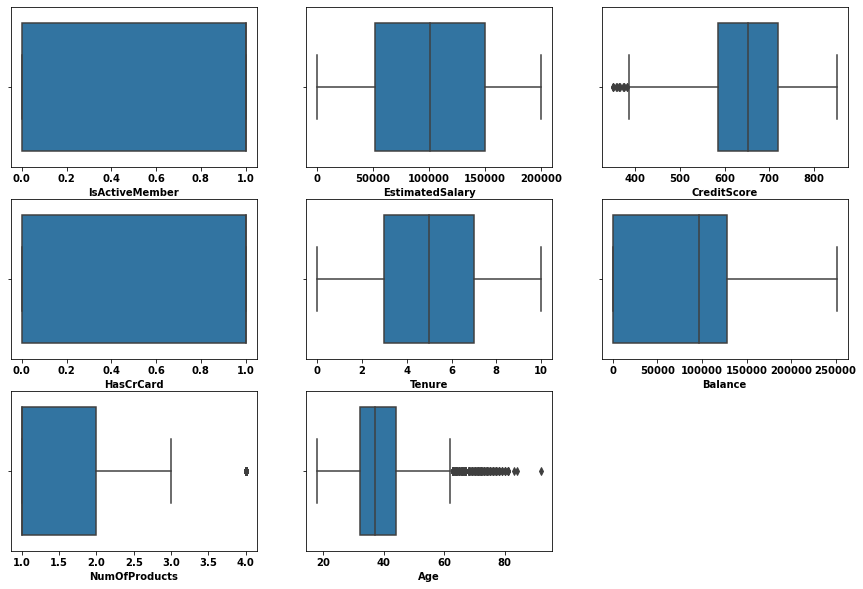

In [10]:
#Check Outliers
plt.figure(figsize=(15,10))
for i, col in enumerate(train_data[num_cols]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x = train_data[col]) 
plt.show()


### `2.5` Check Highly correlated features

<AxesSubplot:>

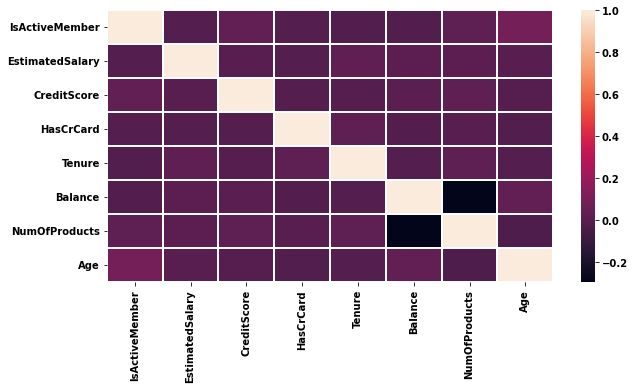

In [11]:
# making a heatmap to inspect the highly correlated features
corr_matrix = train_data[num_cols].corr()
plt.subplots(figsize = (10, 5))
sns.heatmap(corr_matrix, 
           xticklabels = corr_matrix.columns.values,
           yticklabels = corr_matrix.columns.values, 
           linewidth = 0.1)

### `2.6` Check Imbalance

0    6356
1    1644
Name: Exited, dtype: int64


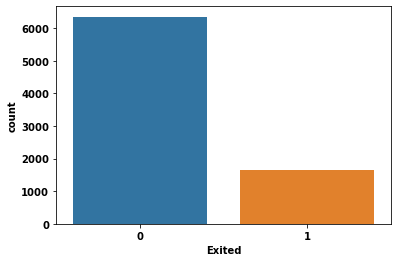

In [12]:
print(train_data['Exited'].value_counts())
_ = sns.countplot(x='Exited', data=train_data)

### `2.7` Check Categorical Data

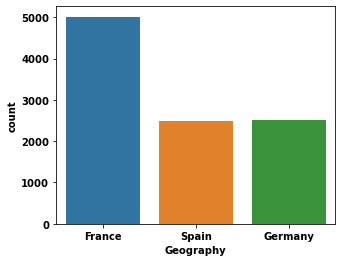

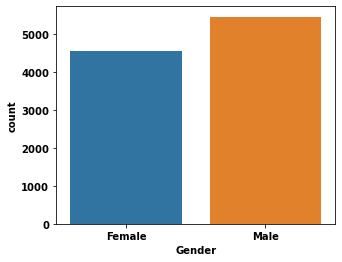

In [17]:
for i in cat_cols:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    sns.countplot(x=i ,data = df)
    plt.show()

 
> ### **Observations :**
> Data have : 
> 1. Skewness <br>
> 2. Outliers <br>
> 3. Imbalanced
>
>




## `03` Data Preprocessing

#### `3.1` Handling Outliers

In [17]:
def bounds_calc(train_data, col, boundry_threshold):
  Q1 = np.percentile(train_data[col], q = 25, interpolation = 'midpoint')
  Q3 = np.percentile(train_data[col], q = 75, interpolation = 'midpoint')
  IQR = Q3 - Q1
  Upper_Bound = Q3 + boundry_threshold * IQR
  Lower_Bound = Q1 - boundry_threshold * IQR
  return Lower_Bound, Upper_Bound
    
def outliers_clamping(Lower_Bound, Upper_Bound, value):
  if value > Upper_Bound:
    return Upper_Bound
  elif value < Lower_Bound:
    return Lower_Bound
  else:
    return value

def outliers_handling(train_data, validation_data, boundry_threshold):
    num_data = list(set(train_data.select_dtypes(exclude=[object]).columns) - set(['CustomerId', 'Exited']))
    for col in num_data:
        Lower_Bound, Upper_Bound = bounds_calc(train_data, col, boundry_threshold)
        train_data[col] = train_data[col].apply(lambda x : outliers_clamping(Lower_Bound, Upper_Bound, x))
        validation_data[col] = validation_data[col].apply(lambda x : outliers_clamping(Lower_Bound, Upper_Bound, x))
    return train_data, validation_data


#### `3.2` Handling Skewness

In [18]:
def skewness_calc(col ,df):
    std_col = np.std(df[col])
    mean_col = np.mean(df[col])
    size_rows = df.count()[0]
    skewness = np.sum(np.power(df[col] - mean_col, 3))/((size_rows - 1) * np.power(std_col, 3))
    return skewness

def skewed_data_transformation(value):
  return np.log(1 + np.abs(value))

def skewness_handling(train_data, validation_data):
    num_data = list(set(train_data.select_dtypes(exclude=[object]).columns) - set(['CustomerId', 'Exited']))
    skewed_train_cols = []
    for col in num_data: 
        sk = skewness_calc(col, train_data)
        if (np.abs(sk) >= 1):
            skewed_train_cols.append(col)
            train_data[col] = train_data[col].apply(lambda x : skewed_data_transformation(x))
            validation_data[col] = validation_data[col].apply(lambda x : skewed_data_transformation(x))
    return train_data, validation_data

#### `3.3` Feature Scaling

##### `3.3.1 ` Shapiro-Wilk(Normal Distribution) test

In [19]:
def Shapiro_Wilk_test (df, num_cols, alpha):
    feats_std_scale = []
    feats_min_max_scale = []
    for col in num_cols:
        stat, p = shapiro(df[col])
        # print('W_Statistic=%.3f, p=%.8f' % (stat, p))

        if p > alpha:
            # print(f'{col} looks like gaussian (fail to reject H0)')
            feats_std_scale.append(col)
        else:
            # print(f'{col} does not look Gaussian (reject H0)')
            feats_min_max_scale.append(col)

    # print("features to be scaled with min max",  feats_min_max_scale)
    # print("features to be scaled with standarization",  feats_std_scale)
    return feats_min_max_scale, feats_std_scale

##### `3.3.2 ` Scaling Features

In [20]:
# brute force code , Don't forget to enhance ittttttt  ----------------->
def scaling_features (train_data, validation_data, alpha):
    num_data = list(set(train_data.select_dtypes(exclude=[object]).columns) - set(['CustomerId']))
    feats_min_max_scale, feats_std_scale = Shapiro_Wilk_test(train_data, num_data, alpha)
    
    if len(feats_std_scale) <= 0  :
        min_max_scaler = MinMaxScaler()
        min_max_scaler_model = min_max_scaler.fit(train_data[feats_min_max_scale])
        min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(train_data[feats_min_max_scale]), columns = feats_min_max_scale)
        min_max_scaled_validation_data = pd.DataFrame(min_max_scaler_model.transform(validation_data[feats_min_max_scale]), columns = feats_min_max_scale)
        num_train_data = min_max_scaled_train_data
        num_validation_data = min_max_scaled_validation_data
    elif len(feats_min_max_scale) <= 0 :
        std_scaler = StandardScaler()
        std_scaler_model = std_scaler.fit(train_data[feats_std_scale])
        std_scaled_train_data = pd.DataFrame(std_scaler_model.transform(train_data[feats_std_scale]), columns = feats_std_scale)
        std_scaled_validation_data = pd.DataFrame(std_scaler_model.transform(validation_data[feats_std_scale]), columns = feats_std_scale)
        num_train_data = std_scaled_train_data
        num_validation_data = std_scaled_validation_data
    else : 
        min_max_scaler = MinMaxScaler()
        min_max_scaler_model = min_max_scaler.fit(train_data[feats_min_max_scale])
        min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(train_data[feats_min_max_scale]), columns = feats_min_max_scale)
        min_max_scaled_validation_data = pd.DataFrame(min_max_scaler_model.transform(validation_data[feats_min_max_scale]), columns = feats_min_max_scale)
        
        std_scaler = StandardScaler()
        std_scaler_model = std_scaler.fit(train_data[feats_std_scale])
        std_scaled_train_data = pd.DataFrame(std_scaler_model.transform(train_data[feats_std_scale]), columns = feats_std_scale)
        std_scaled_validation_data = pd.DataFrame(std_scaler_model.transform(validation_data[feats_std_scale]), columns = feats_std_scale)
        
        num_train_data = std_scaled_train_data.merge(min_max_scaled_train_data, right_index = True, left_index = True)
        num_validation_data = std_scaled_validation_data.merge(min_max_scaled_validation_data, right_index = True, left_index = True)
        
    print("features to be scaled with min max",  feats_min_max_scale)
    print("features to be scaled with standarization",  feats_std_scale)
    
    return num_train_data, num_validation_data

#### `3.4` Handling Categorical Data

In [21]:

def handling_catecorical(df, ordinal_cats, nominal_cats):
    ordinal_train_df = pd.DataFrame()
    for ordinal_feat in ordinal_cats:
        label_enc_model = LabelEncoder().fit(df[ordinal_feat])
        ordinal_train_df[ordinal_feat] = label_enc_model.transform(df[ordinal_feat])
        
    one_hot_enc_model = OneHotEncoder(sparse = False).fit(df[nominal_cats])
    nominal_train_data = one_hot_enc_model.transform(df[nominal_cats])

    a=one_hot_enc_model.categories_
    col_names=[]
    for list_ in a:
        for element in list_:
            col_names.append(element)

    nominal_train_df = pd.DataFrame(nominal_train_data, columns = col_names)
    return nominal_train_df, ordinal_train_df

### `3.5` Merge Data

In [22]:
def merge_final_data(nominal_train_df, ordinal_train_df, num_train_df, nominal_test_df, ordinal_test_df, num_validation_df):
    final_train_data = nominal_train_df.merge(num_train_df, right_index = True, left_index = True, how = 'inner')
    final_test_data = nominal_test_df.merge(num_validation_df, right_index = True, left_index = True, how = 'inner')

    return final_train_data, final_test_data

### **Pre-Processing Function** 

In [23]:
def pre_processing(train_data, validation_data, ordinal_cats, nominal_cats,boundry_threshold, shapiro_alpha):

    #1) outliers handling for the whole data using training data boundries
    train_data, validation_data = outliers_handling(train_data, validation_data, boundry_threshold)
    print(f"After outliers_handling > train Data = {train_data.shape}, val data = {validation_data.shape} ")

    #2) skewness handling for the whole data training data boundries
    train_data, validation_data = skewness_handling(train_data, validation_data)
    print(f"After skewness_handling > train Data = {train_data.shape}, val data = {validation_data.shape} ")

    #3) Scaling Features
    num_train_df, num_validation_df = scaling_features (train_data, validation_data, shapiro_alpha)
    print(f"After scaling_features > train Data = {train_data.shape}, val data = {validation_data.shape} ")

    #4) handling categorical data 
    nominal_train_df, ordinal_train_df = handling_catecorical(train_data, ordinal_cats, nominal_cats)
    nominal_test_df, ordinal_test_df = handling_catecorical(validation_data, ordinal_cats, nominal_cats)
    print(f" After handling_catecorical > train Data = {train_data.shape}, val data = {validation_data.shape} ")

    #5) Merge all these stuff together
    final_train_data, final_test_data = merge_final_data(nominal_train_df, ordinal_train_df, num_train_df, nominal_test_df, ordinal_test_df, num_validation_df)

    return final_train_data, final_test_data

In [24]:
final_train_data, final_test_data = pre_processing( train_data,
                                                    validation_data,
                                                    ordinal_cols,
                                                    nominal_cols,
                                                    boundry_threshold = 1.5,
                                                    shapiro_alpha = 0.05
                                                    )     

print(f'final_train_data shape = {final_train_data.shape}')  
print(f'final_test_data shape = {final_test_data.shape}')  

After outliers_handling > train Data = (8000, 12), val data = (2000, 12) 
After skewness_handling > train Data = (8000, 12), val data = (2000, 12) 
features to be scaled with min max ['EstimatedSalary', 'Exited', 'CreditScore', 'NumOfProducts', 'IsActiveMember', 'Balance', 'Age', 'Tenure', 'HasCrCard']
features to be scaled with standarization []
After scaling_features > train Data = (8000, 12), val data = (2000, 12) 
 After handling_catecorical > train Data = (8000, 12), val data = (2000, 12) 
final_train_data shape = (8000, 14)
final_test_data shape = (2000, 14)


c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [25]:
len(final_train_data[final_train_data['Exited'] == 1])/ len(final_train_data)

0.2055

### `3.6` Under Sample Final Train Data To handle Imblanced Data


In [26]:
rare_class_data = final_train_data[final_train_data['Exited'] == 1]
dominant_class_data = final_train_data[final_train_data['Exited'] == 0]
final_train_data['Exited'].value_counts()

0.0    6356
1.0    1644
Name: Exited, dtype: int64

In [27]:
under_sampled_class = dominant_class_data.sample(frac = 0.2, replace = False, random_state = 42)
train_undersampled = pd.concat((under_sampled_class, rare_class_data), axis = 0)
train_undersampled['Exited'].value_counts()

1.0    1644
0.0    1271
Name: Exited, dtype: int64

## `04 ` Split Data into dependent cols and response col (X, Y)

In [28]:
X_train = train_undersampled.loc[:, train_undersampled.columns!='Exited']
Y_train = train_undersampled[target]

print(f'X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}')

X_test = final_test_data.loc[:, final_test_data.columns!='Exited']
Y_test = final_test_data[target]
print(f'X_test shape : {X_test.shape}, Y_test shape : {Y_test.shape}')



X_train shape : (2915, 13), Y_train shape : (2915, 1)
X_test shape : (2000, 13), Y_test shape : (2000, 1)


In [29]:
X_test.head(5)

,Female,Male,France,Germany,Spain,EstimatedSalary,CreditScore,NumOfProducts,IsActiveMember,Balance,Age,Tenure,HasCrCard
0,0.0,1.0,0.0,1.0,0.0,0.208616,0.454936,0.4,0.0,0.385452,0.318182,0.3,0.0
1,0.0,1.0,1.0,0.0,0.0,0.731883,0.512876,0.4,1.0,0.000000,0.568182,0.1,1.0
2,1.0,0.0,0.0,0.0,1.0,0.292531,0.465665,0.4,0.0,0.000000,0.590909,0.4,1.0
3,0.0,1.0,0.0,1.0,0.0,0.853458,0.261803,0.4,1.0,0.474902,0.931818,0.8,1.0
4,1.0,0.0,0.0,0.0,1.0,0.573241,0.377682,0.0,1.0,0.498194,0.204545,0.7,1.0


## `05`  Finaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaally Training The Model :D 

## `5.1` Logistic Regression

AUC =  0.7853047497351758


c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\utils\validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


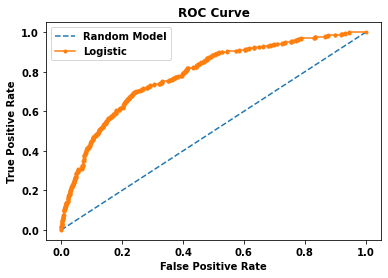

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix

# fit a model
model = LogisticRegression(random_state=42, max_iter=2000)
model.fit(X_train.values, Y_train.values)

# predict probabilities
y_pred = model.predict_proba(X_test.values)

# keep probabilities for the positive outcome only
y_pred_prob = y_pred[:, [1]]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

# Area under curve (AUC)
auc = roc_auc_score(Y_test, y_pred_prob)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random Model')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

print('AUC = ', auc)
# show the plot
plt.show()

In [22]:
Logistic_y_train_pred = model.predict(X_train.values).reshape(-1, 1)
Logistic_y_test_pred = model.predict(X_test.values).reshape(-1, 1)

print("Train Data : \n", classification_report( Y_train, Logistic_y_train_pred))
print("Validation Data : \n", classification_report(Y_test, Logistic_y_test_pred))

Train Data : 
               precision    recall  f1-score   support

         0.0       0.70      0.63      0.66      1271
         1.0       0.74      0.79      0.76      1644

    accuracy                           0.72      2915
   macro avg       0.72      0.71      0.71      2915
weighted avg       0.72      0.72      0.72      2915

Validation Data : 
               precision    recall  f1-score   support

         0.0       0.92      0.63      0.74      1607
         1.0       0.34      0.77      0.47       393

    accuracy                           0.66      2000
   macro avg       0.63      0.70      0.61      2000
weighted avg       0.80      0.66      0.69      2000



c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


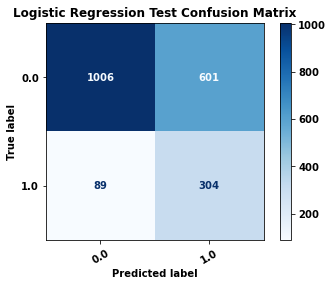

In [23]:
plot_confusion_matrix(model, X_test, Y_test, cmap='Blues')  
plt.xticks(rotation=30)
plt.title('Logistic Regression Test Confusion Matrix')
plt.show() 

## `5.2` SVM

In [30]:
C = [0.001, 0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1, 10, 100]
degrees = [2, 4, 6]

## **Linear Kernal SVM**

### `01` Manual Search

In [48]:
max_score = 0.0
best_c =  0
adj_r_squared_train =  []
for c in C :
    SVC_sklearn  = SVC(kernel = 'linear', C = c)
    fitted_SVC_Sklearn = SVC_sklearn.fit(X_train.values, Y_train.values.ravel())
    SVC_y_train_pred = fitted_SVC_Sklearn.predict(X_train.values).reshape(-1, 1)
    curr_score = f1_score(Y_train, SVC_y_train_pred)
    if curr_score > max_score:
        best_c= c
        max_score = curr_score

print("The appropriate C is : ", best_c)

The appropriate C is :  0.1


In [25]:
SVC_sklearn  = SVC(kernel = 'linear', C = 0.1)
fitted_SVC_Sklearn = SVC_sklearn.fit(X_train.values, Y_train.values.ravel())

SVC_y_train_pred = fitted_SVC_Sklearn.predict(X_train.values).reshape(-1, 1)
SVC_y_test_pred = fitted_SVC_Sklearn.predict(X_test.values).reshape(-1,1)

print("Train Data : \n", classification_report(Y_train, SVC_y_train_pred))
print("Validation Data : \n", classification_report(Y_test, SVC_y_test_pred))

Train Data : 
               precision    recall  f1-score   support

         0.0       0.69      0.63      0.66      1271
         1.0       0.73      0.78      0.76      1644

    accuracy                           0.72      2915
   macro avg       0.71      0.71      0.71      2915
weighted avg       0.72      0.72      0.72      2915

Validation Data : 
               precision    recall  f1-score   support

         0.0       0.92      0.63      0.75      1607
         1.0       0.34      0.76      0.47       393

    accuracy                           0.66      2000
   macro avg       0.63      0.70      0.61      2000
weighted avg       0.80      0.66      0.69      2000



### `02` Using Grid Search

In [50]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'kernel': ['linear']}
 
grid = GridSearchCV(SVC(), param_grid, cv = 5)
 
# fitting the model for grid search
grid.fit(X_train, Y_train.values.ravel())
print("Best hyper_parameters for Linear kernal is : ", grid.best_params_)
print("Best Score for Linear kernal is : ", grid.best_score_)

Best hyper_parameters for Linear kernal is :  {'C': 1, 'kernel': 'linear'}
Best Score for Linear kernal is :  0.7200686106346483


In [27]:
svclassifier = SVC(C = 1, kernel='linear')
svclassifier.fit(X_train, Y_train.values.ravel())

SVC_y_train_pred = svclassifier.predict(X_train)
SVC_y_test_pred = svclassifier.predict(X_test)
print("Train Data : \n", classification_report(Y_train, SVC_y_train_pred ))
print("Validation Data : \n", classification_report(Y_test, SVC_y_test_pred ))


Train Data : 
               precision    recall  f1-score   support

         0.0       0.69      0.66      0.67      1271
         1.0       0.74      0.77      0.76      1644

    accuracy                           0.72      2915
   macro avg       0.72      0.71      0.71      2915
weighted avg       0.72      0.72      0.72      2915

Validation Data : 
               precision    recall  f1-score   support

         0.0       0.92      0.65      0.76      1607
         1.0       0.35      0.76      0.48       393

    accuracy                           0.67      2000
   macro avg       0.63      0.71      0.62      2000
weighted avg       0.81      0.67      0.70      2000



c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


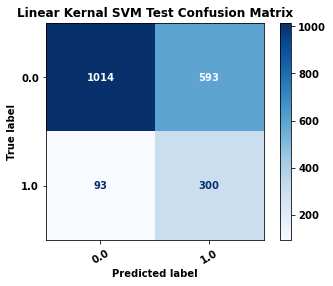

In [29]:
plot_confusion_matrix(SVC_sklearn, X_test, Y_test, cmap='Blues')  
plt.xticks(rotation=30)
plt.title('Linear Kernal SVM Test Confusion Matrix')
plt.show() 

## **Polynomial Kernal SVM**

### `01` Manual Search

In [52]:
# max_score = 0.0
# best_c, best_gamma, best_degree = 0, 0, 0
# for c in C :
#     for gamma in gammas:
#         # for degree in degrees: 
#                 SVC_sklearn  = SVC(kernel = 'poly', C = c, gamma= gamma, degree = 2)
#                 fitted_SVC_Sklearn = SVC_sklearn.fit(X_train.values, Y_train.values.ravel())
#                 SVC_y_train_pred = fitted_SVC_Sklearn.predict(X_train.values).reshape(-1, 1)
#                 curr_score = f1_score(Y_train, SVC_y_train_pred)
#                 if curr_score > max_score:
#                     best_c, best_gamma, best_degree = c, gamma, 2
#                     max_score = curr_score

# print("The appropriate C is : ", best_c)
# print("The appropriate gamma is : ", best_gamma)
# print("The appropriate Degree is : ", best_degree)


In [36]:
SVC_sklearn  = SVC(kernel = 'poly', C = 100, gamma= 0.1, degree = 3)
fitted_SVC_Sklearn = SVC_sklearn.fit(X_train.values, Y_train.values.ravel())
SVC_y_train_pred = fitted_SVC_Sklearn.predict(X_train.values)
SVC_y_test_pred = fitted_SVC_Sklearn.predict(X_test.values)

# print(f"when C = {best_c}, gamma = {best_gamma}, degree = {best_degree} :")
print("Train Data : \n", classification_report(Y_train, SVC_y_train_pred ))
print("Validation Data : \n", classification_report(Y_test, SVC_y_test_pred))


Train Data : 
               precision    recall  f1-score   support

         0.0       0.76      0.76      0.76      1271
         1.0       0.82      0.82      0.82      1644

    accuracy                           0.79      2915
   macro avg       0.79      0.79      0.79      2915
weighted avg       0.79      0.79      0.79      2915

Validation Data : 
               precision    recall  f1-score   support

         0.0       0.93      0.71      0.81      1607
         1.0       0.40      0.79      0.53       393

    accuracy                           0.73      2000
   macro avg       0.67      0.75      0.67      2000
weighted avg       0.83      0.73      0.75      2000



### `02` Grid Search

In [ ]:
# from sklearn.model_selection import GridSearchCV
 
# # defining parameter range
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
#               'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'degree': [2, 3, 4, 5, 6],
#               'kernel': ['poly']}
 
# grid = GridSearchCV(SVC(), param_grid)
 
# # fitting the model for grid search
# grid.fit(X_train, y_train.values.ravel())

In [ ]:
# print("Best hyper_parameters for rbf is : ", grid.best_params_)
# print(classification_report(y_pred, y_train))

c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


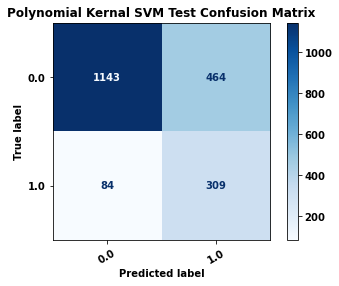

In [37]:
plot_confusion_matrix(SVC_sklearn, X_test, Y_test, cmap='Blues')  
plt.xticks(rotation=30)
plt.title('Polynomial Kernal SVM Test Confusion Matrix')
plt.show() 

## **RBF Kernal SVM**

### `01` Manual Search

In [32]:
max_score = 0.0
best_c, best_gamma = 0, 0
for c in C :
    for gamma in gammas:
            SVC_sklearn  = SVC(kernel = 'rbf', C = c, gamma= gamma)
            fitted_SVC_Sklearn = SVC_sklearn.fit(X_train.values, Y_train.values.ravel())
            SVC_y_train_pred = fitted_SVC_Sklearn.predict(X_train.values).reshape(-1, 1)
            curr_score = f1_score(Y_train, SVC_y_train_pred)
            if curr_score > max_score:
                best_c, best_gamma= c, gamma
                max_score = curr_score

print("The appropriate C is : ", best_c)
print("The appropriate gamma is : ", best_gamma)


The appropriate C is :  10
The appropriate gamma is :  100


In [35]:
SVC_sklearn  = SVC(kernel = 'rbf', C = 10, gamma= 100)
fitted_SVC_Sklearn = SVC_sklearn.fit(X_train.values, Y_train.values.ravel())
SVC_y_train_pred = fitted_SVC_Sklearn.predict(X_train.values)
SVC_y_test_pred = fitted_SVC_Sklearn.predict(X_test.values)

print(f"when C = {best_c}, gamma = {best_gamma} : ")
print("Train Data : \n", classification_report(Y_train, SVC_y_train_pred))
print("Validation Data : \n", classification_report(Y_test, SVC_y_test_pred))


when C = 10, gamma = 100 : 
Train Data : 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1271
         1.0       1.00      1.00      1.00      1644

    accuracy                           1.00      2915
   macro avg       1.00      1.00      1.00      2915
weighted avg       1.00      1.00      1.00      2915

Validation Data : 
               precision    recall  f1-score   support

         0.0       0.91      0.06      0.11      1607
         1.0       0.20      0.98      0.34       393

    accuracy                           0.24      2000
   macro avg       0.56      0.52      0.22      2000
weighted avg       0.77      0.24      0.15      2000



### `02` Grid Search

In [30]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10, 100],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, cv = 5)
 
# fitting the model for grid search
grid.fit(X_train.values,  Y_train.values.ravel())
print("Best hyper_parameters for rbf is : ", grid.best_params_)
print("Best Score for rbf is : ", grid.best_score_)


Best hyper_parameters for rbf is :  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score for rbf is :  0.7636363636363637


In [31]:
fitted_SVC_Sklearn = SVC(C = 100, gamma = 0.1, kernel='rbf')
fitted_SVC_Sklearn.fit(X_train, Y_train.values.ravel())
SVC_y_train_pred = fitted_SVC_Sklearn.predict(X_train.values)
SVC_y_test_pred = fitted_SVC_Sklearn.predict(X_test.values)

print("Train Data : \n", classification_report(Y_train, SVC_y_train_pred))
print("Validation Data : \n", classification_report(Y_test, SVC_y_test_pred))


c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Train Data : 
               precision    recall  f1-score   support

         0.0       0.77      0.76      0.77      1271
         1.0       0.82      0.83      0.82      1644

    accuracy                           0.80      2915
   macro avg       0.80      0.79      0.79      2915
weighted avg       0.80      0.80      0.80      2915

Validation Data : 
               precision    recall  f1-score   support

         0.0       0.94      0.71      0.81      1607
         1.0       0.40      0.80      0.53       393

    accuracy                           0.73      2000
   macro avg       0.67      0.75      0.67      2000
weighted avg       0.83      0.73      0.75      2000



c:\Users\CRIZMA MEGA STORE\AppData\Local\Programs\Orange\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


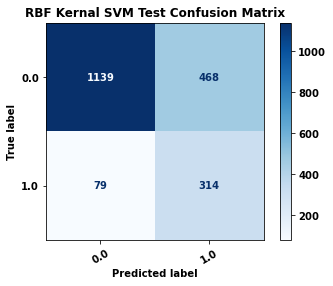

In [35]:
plot_confusion_matrix(fitted_SVC_Sklearn, X_test, Y_test, cmap='Blues')  
plt.xticks(rotation=30)
plt.title('RBF Kernal SVM Test Confusion Matrix')
plt.show() 

### `a.` Curve demonstrating the effect of changing C on the F1-score of the train-data

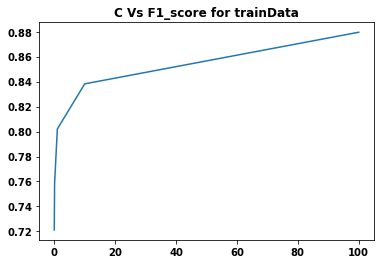

In [36]:
from sklearn.metrics import f1_score
f1_score_ls = []
for c in C : 
    svclassifier = SVC(C = c, kernel='rbf')
    svclassifier.fit(X_train, Y_train.values.ravel())
    y_pred = svclassifier.predict(X_train)
    f1_score_ls.append(f1_score(Y_train, y_pred))
plt.title('C Vs F1_score for trainData')

plt.plot(C, f1_score_ls)

### `b.`	Curve demonstrating the effect of changing C on the F1-score of the validation-data

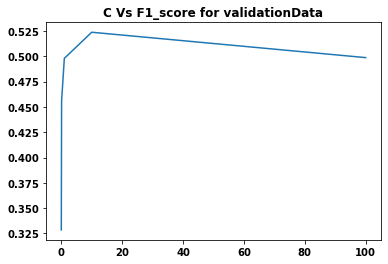

In [37]:
f1_score_ls = []
for c in C : 
    svclassifier = SVC(C = c, kernel='rbf')
    svclassifier.fit(X_train, Y_train.values.ravel())
    y_pred = svclassifier.predict(X_test)
    f1_score_ls.append(f1_score(Y_test, y_pred))
plt.title('C Vs F1_score for validationData')

plt.plot(C, f1_score_ls)

### `c.` Curve demonstrating the effect of changing Gamma  on the F1-score of the train-data

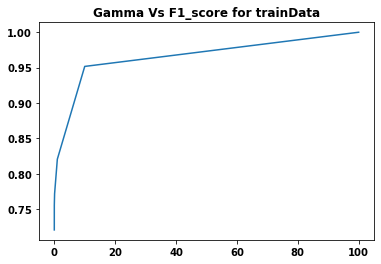

In [38]:
f1_score_ls = []
for gamma in gammas : 
    svclassifier = SVC(kernel='rbf', gamma = gamma)
    svclassifier.fit(X_train, Y_train.values.ravel())
    y_pred = svclassifier.predict(X_train)
    f1_score_ls.append(f1_score(Y_train, y_pred))
plt.title('Gamma Vs F1_score for trainData')

plt.plot(gammas, f1_score_ls)

### `d.`	Curve demonstrating the effect of changing Gamma  on the F1-score of the validation-data

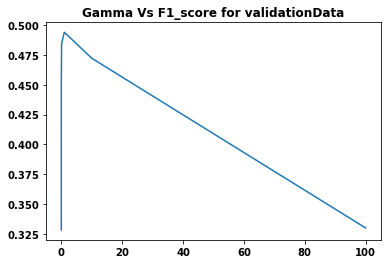

In [39]:
f1_score_ls = []
for gamma in gammas : 
    svclassifier = SVC(kernel='rbf', gamma = gamma)
    svclassifier.fit(X_train, Y_train.values.ravel())
    y_pred = svclassifier.predict(X_test)
    f1_score_ls.append(f1_score(Y_test, y_pred))
plt.title('Gamma Vs F1_score for validationData')
plt.plot(gammas, f1_score_ls)

# To sum all the results up, we have :

|       Models          | f1_score in Train  |f1_score in Test  | C     | gamma | Degree
|-------------------    |-------        |-------  |-------    |-------    |-------
| Logistic Regression   | 0.72   |  0.66   |   -       | -| - |
| Linear Kernal SVM     | 0.72   |  0.67	| 1   	|   -   | - |
| Poly Kernal SVM     	| 0.79   |  0.73  	|   100   	|   0.1   | 3 |
| RBF Kernal SVM      	| 0.80   |  0.73 	|   100   	|   0.1  | - |
# ____________________________________________________________________
